In [1]:
'''
实现文本分类
'''

'\n实现文本分类\n'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 读取数据

In [3]:
def read_data(file_path):
    data_all = pd.read_csv(file_path,sep='\t')
    print("data_all shape is :",data_all.shape)
    # x = pd.read_csv(file_path,sep='\t',usecols = ['Phrase'])
    # y = pd.read_csv(file_path,sep='\t',usecols = ['Sentiment'])
    x = data_all['Phrase'].values
    y = data_all['Sentiment'].values
    x = x[:1000]
    y = y[:1000]
    
    return x,y

## 文本特征表示

In [4]:
train_path = 'data/train.tsv'
X, y = read_data(train_path)
print("X shape is",X.shape)
print("y shape is",y.shape)


data_all shape is : (156060, 4)
X shape is (1000,)
y shape is (1000,)


In [5]:
# BagOfWord词袋表示
class BagOfWord:
    def __init__(self, do_lower_case = False):
        # 元组形式
        self.vocab = {}
        self.do_lower_case = do_lower_case

    # 构建文档词汇字典
    # CountVectorizer.fit
    def fit(self, data_list):
        for sentence in data_list:
            if self.do_lower_case:
                sentence = sentence.lower()
            words = sentence.strip().split(" ")
            for word in words:
                if word not in self.vocab:
                    # 元素值为下标索引值
                    self.vocab[word] = len(self.vocab)
    
    # document-term matrix, count the frequency
    def transform(self, data_list):
        vocab_size = len(self.vocab)
        document_term_matrix = []
        

        for idx, sentence in enumerate(data_list):
            temp = np.zeros(vocab_size,dtype='int8')
            if self.do_lower_case:
                sentence = sentence.lower()
            words = sentence.strip().split(" ")
            for word in words:
                vocab_idex = self.vocab[word]
                temp[vocab_idex] += 1
                
            document_term_matrix.append(temp)

        return document_term_matrix

    def fit_transform(self, data_list):
        self.fit(data_list)
        return self.transform(data_list)


In [6]:
# N-gram表示
class NGram:
    def __init__(self, ngram_range, do_lower_case = False):
        # 元组形式
        self.ngram_vocab = {}
        self.ngram_range = ngram_range
        self.do_lower_case = do_lower_case

    # 构建文档词汇字典
    # CountVectorizer.fit
    def fit(self, data_list):
        for gram in self.ngram_range:
            for sentence in data_list:
                if self.do_lower_case:
                    sentence = sentence.lower()
                words = sentence.strip().split(" ")
                for i in range(len(words) - gram + 1):
                    n_gram_word = "_".join(words[i : i + gram])
                    if n_gram_word not in self.ngram_vocab:
                        # 元素值为下标索引值
                        self.ngram_vocab[n_gram_word] = len(self.ngram_vocab)
    
    # document-term matrix, count the frequency
    def transform(self, data_list):

        vocab_size = len(self.ngram_vocab)
        document_term_matrix = []
        

        for idx, sentence in enumerate(data_list):
            temp = np.zeros(vocab_size,dtype='int8')
            if self.do_lower_case:
                sentence = sentence.lower()
            words = sentence.strip().split(" ")
            for gram in self.ngram_range:
                for i in range(len(words) - gram + 1):
                    n_gram_word = "_".join(words[i : i + gram])
                    if n_gram_word in self.ngram_vocab:
                        vocab_idex = self.ngram_vocab[n_gram_word]
                        temp[vocab_idex] += 1
                   
            document_term_matrix.append(temp)
        
        return document_term_matrix

    def fit_transform(self, data_list):
        self.fit(data_list)
        return self.transform(data_list)

## 分类器：Logistic regression

In [7]:
def sigmoid(z):
    g = np.zeros(z.size)
    g = 1 / (1 + np.exp(-z))

    return g

In [8]:
import scipy.optimize as opt

In [9]:
def lr_cost_function(theta, X, y, lmd):
    m = y.size

    # You need to return the following values correctly
    cost = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(np.dot(X, theta))
    # 排除theta0
    reg = lmd * np.sum(theta[1:] ** 2) / (2 * m)
    sum = np.dot(y, np.log(h)) + np.dot(1 - y, np.log(1 - h))
    cost = -sum / m + reg
    error = h.flatten() - y

    # np.sum当axis为0时, 是压缩行, 即将每一列的元素相加, 将矩阵压缩为一行
    normal_grad = (1 / m) * np.sum(X * error[:, np.newaxis], 0)
    # don't regularize the parameter theta 0,单独进行处理
    grad[0] = normal_grad[0]
    grad[1:] = normal_grad[1:] + lmd * theta[1:] / m

    return cost, grad

def one_vs_all(X, y, num_labels, lmd):
    # Some useful variables
    X = np.array(X)
    (m, n) = X.shape

    # You need to return the following variables correctly,设定theta的维度
    # 总的参数向量维度是K×n(本例中为10×401)，相当于构建了K个分类器，每个分类器最后都会得到一个优化参数集
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data 2D-array
    X = np.c_[np.ones(m), X]

    for i in range(num_labels):
        # Initialize fitting parameters
        theta_i = np.zeros(n + 1)
        # y==i表示当前分类器需要判别 y属于哪个标签值,属于当前标签为1，不属于为0
        y_i = (y == i)
        print('Optimizing for label {}...'.format(i))

        def cost_func(t):
            return lr_cost_function(t, X, y_i, lmd)[0]

        def grad_func(t):
            return lr_cost_function(t, X, y_i, lmd)[1]

        all_theta[i:], *unused = opt.fmin_cg(cost_func, fprime=grad_func, x0=theta_i,
                                    maxiter=100, disp=False, full_output=True)
        print('Done')

    return all_theta

def predict_one_vs_all(all_theta, X):
    X = np.array(X)
    m = X.shape[0]

    # You need to return the following variable correctly;
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.c_[np.ones(m), X]
    # 与之前的predict函数相同，计算出每个lable的h_i(X)，取出最大值


    # 5000个样本，每个样本都有10个预测输出（概率值）
    result = sigmoid(np.dot(all_theta, X.T))  # (10,401) (5000,401)^T=>(10,5000)
    # np.roll沿着给定轴滚动数组元素。超出最后位置的元素将会滚动到第一个位置。
    # （将a，沿着axis的方向，滚动shift长度）
    result = np.roll(result, -1, axis=0)    # 5000列同时在垂直方向向上滚动1个位置
    # np.vstack:按垂直方向（行顺序）堆叠数组构成一个新的数组
    result = np.vstack((np.zeros(m), result))   #  (1,5000) + (10,5000)  = (11,5000)
    # 先上移在添一行全为0的数组，是因为算出0的概率在第一行，9在最后一行
    # 而np.argmax，默认按列方向搜索最大值,返回的是索引所在的行数，这样能消除下标以及10代表0的作用
    p = np.argmax(result, axis=0)   # p = (1,5000)
    return p

## 分类器：softmax  regression

In [10]:
def softmax(x):
    x -= np.max(x, axis = 1, keepdims = True)
    exp_x = np.exp(x)
    z = exp_x / np.sum(exp_x, axis = 1, keepdims = True)
    return z 


In [11]:
class softmaxRegression:
    def __init__(self):
        # 变量初始化
        self.weight = None              # 模型权重
        self.learning_rate = None       # 模型学习率
        self.class_num = None           # 类别数量
        self.m = None                   # 样本数量
        self.n = None                   # 特征维数

    def fit(self, X, y, learning_rate, epoch_num, class_num, print_steps, update_strategy):
        X = np.array(X)
        self.m, self.n = X.shape
        self.class_num = class_num
        self.weight = np.random.randn(self.n, self.class_num)
        self.learning_rate = learning_rate

        # 类别y转换为独热编码
        y_one_hot = np.zeros((self.m, self.class_num))
        for i in range(self.m):
            y_one_hot[i][y[i]] = 1

        # 记录损失函数值
        loss_history = []
        for epoch in range(epoch_num):
            loss = 0

            if update_strategy == "stochastic":
                random_index = np.arange(len(X))
                np.random.shuffle(random_index)
                for index in list(random_index):
                    
                    #print("weight.shape",self.weight.shape)
                    X_i = X[index]
                    z = np.dot(X_i,self.weight).reshape(1,self.class_num)
                    
                    predict = softmax(z).flatten()
                    loss -= np.log(predict[y[index]])
                    grad = X_i.reshape(self.n,1).dot((y_one_hot[index] - predict).reshape(1, self.class_num))
                    
                    self.weight += grad

            
            if update_strategy == "batch":
                # X--(m,n), weight--(n,class_num)
                
                z = np.dot(X, self.weight)
                predict = softmax(z)

                # 构造同维度的梯度矩阵
                grad = np.zeros_like(self.weight)

                # 损失函数 & 梯度下降更新
                for i in range(self.m):
                    loss -= np.log(predict[i][y[i]])
                    grad += X[i].reshape(self.n,1).dot((y_one_hot[i] - predict[i]).reshape(1, self.class_num))
                
                # grad = np.dot(X.T, (y_one_hot - predict))
                self.weight += self.learning_rate * grad / self.m

            loss /= self.m
            loss_history.append(loss)
            if print_steps != -1 and epoch % print_steps == 0:
                print("epoch {} loss {}".format(epoch, loss))
        return loss_history

    def predict(self, X):
        z = np.dot(X, self.weight)
        pred = softmax(z)
        return pred.argmax(axis = 1)

    def score(self, X, y):
        pred = self.predict(X)
        return np.sum(pred.reshape(y.shape) == y) / y.shape[0]

## 建模训练过程

## logistic回归

In [12]:
bow_model = BagOfWord(do_lower_case = True)
ngram_model = NGram(ngram_range = (1,2), do_lower_case = True)
X_bow = bow_model.fit_transform(X)
X_ngram = ngram_model.fit_transform(X)

lmd = 0.1
num_labels = 5
X_lr_train, X_lr_val, y_lr_train, y_lr_val = train_test_split(X_bow, y, test_size = 0.2, stratify = y)
all_theta = one_vs_all(X_lr_train, y_lr_train, num_labels, lmd)
pred_train = predict_one_vs_all(all_theta, X_lr_train)
pred_val = predict_one_vs_all(all_theta, X_lr_val)

print('Training set accuracy: {}'.format(np.mean(pred_train == y_lr_train)*100))
print('Validation set accuracy: {}'.format(np.mean(pred_val == y_lr_val)*100))



Optimizing for label 0...
Done
Optimizing for label 1...
Done
Optimizing for label 2...
Done
Optimizing for label 3...
Done
Optimizing for label 4...
Done
Training set accuracy: 88.75
Validation set accuracy: 70.0


## softmax 回归

epoch 0 loss 3.138006104886811
epoch 10 loss 1.8274986577380268
epoch 20 loss 1.6688145503835656
epoch 30 loss 1.557334008762635
epoch 40 loss 1.396277148077277
epoch 50 loss 1.6135737619394828
epoch 60 loss 1.7044449930008099
epoch 70 loss 1.5116526306712756
epoch 80 loss 1.6861314690113027
epoch 90 loss 1.6526146298990445


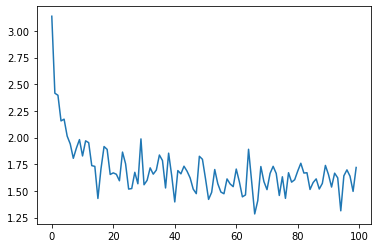

Bow train 0.815 val 0.515
epoch 0 loss 4.313526530164559
epoch 10 loss 1.7320495051641134
epoch 20 loss 0.8618892996642386
epoch 30 loss 0.4627747105964803
epoch 40 loss 0.3421051137776112
epoch 50 loss 0.5422520676363425
epoch 60 loss 0.13758157379271574
epoch 70 loss 0.0644154457213858
epoch 80 loss 0.06461538544085366
epoch 90 loss 0.04032066233593362


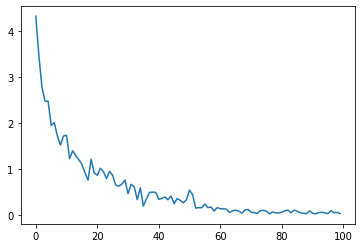

Ngram train 0.9975 val 0.55


In [13]:
X_bow_train, X_bow_val, y_bow_train, y_bow_val = train_test_split(X_bow, y, test_size = 0.2, stratify = y)
X_ngram_train, X_ngram_val, y_ngram_train, y_ngram_val = train_test_split(X_ngram, y, test_size = 0.2, stratify = y)

epoch = 100
bow_learning_rate = 0.1
ngram_learning_rate = 0.1

model1 = softmaxRegression()
history = model1.fit(X_bow_train, y_bow_train, epoch_num = epoch, class_num = 5, learning_rate = bow_learning_rate, print_steps = 10, update_strategy="stochastic")
plt.plot(np.arange(len(history)), np.array(history))
plt.show()
train_score1 = model1.score(X_bow_train, y_bow_train)
val_score1 = model1.score(X_bow_val, y_bow_val)
print("Bow train {} val {}".format(train_score1,val_score1))

model2 = softmaxRegression()
history = model2.fit(X_ngram_train, y_ngram_train, epoch_num = epoch, class_num = 5, learning_rate = ngram_learning_rate, print_steps = 10, update_strategy="stochastic")
plt.plot(np.arange(len(history)), np.array(history))
plt.show()
train_score2 = model2.score(X_ngram_train, y_ngram_train)
val_score2 = model2.score(X_ngram_val, y_ngram_val)
print("Ngram train {} val {}".format(train_score2,val_score2))

## 测试集验证

In [14]:
test_path = 'data/test.tsv'
data_test = pd.read_csv(test_path,sep='\t')
test_id = data_test['PhraseId'].values
x_test = data_test['Phrase'].values
x_test_ngram = ngram_model.transform(x_test)
pred_test = model2.predict(x_test_ngram)
res = np.vstack((test_id, pred_test)).T
submit = pd.DataFrame(res, columns = ['PhraseId', 'Sentiment'])
submit.to_csv('./submit/submit_1.csv',index = False)